資料的突出值要去掉

In [75]:
import pandas as pd
import numpy as np

In [76]:
data = pd.read_csv("./Data/Taipei/h23-g1.csv",delimiter=';')

In [77]:
print(data)

                 date_time            E             N         H  Angle  Axis  \
0      2023-03-22 12:10:00  320191.8741  2.771896e+06  287.4545    0.0   0.0   
1      2023-03-22 12:20:00  320191.8742  2.771896e+06  287.4555    0.0   0.0   
2      2023-03-22 12:30:00  320191.8749  2.771896e+06  287.4554    0.0   0.0   
3      2023-03-22 12:40:00  320191.8757  2.771896e+06  287.4576    0.0   0.0   
4      2023-03-22 12:50:00  320191.8771  2.771896e+06  287.4603    0.0   0.0   
...                    ...          ...           ...       ...    ...   ...   
74028  2024-12-15 10:40:00  320191.8353  2.771896e+06  287.4683   35.0   5.4   
74029  2024-12-15 10:50:00  320191.8353  2.771896e+06  287.4683   36.0   5.2   
74030  2024-12-15 11:00:00  320191.8353  2.771896e+06  287.4683   41.0   6.2   
74031  2024-12-15 11:10:00  320191.8349  2.771896e+06  287.4669   39.0   5.2   
74032  2024-12-15 11:20:00  320191.8341  2.771896e+06  287.4743   65.0   9.3   

       Plate  EMove  NMove  HMove  Tota

In [78]:
data['date_time'] = pd.to_datetime(data['date_time'])
data['date_time'] = data['date_time'].astype('int64') / (10 ** 11)

In [79]:
print(data['date_time'])

0        16794870.0
1        16794876.0
2        16794882.0
3        16794888.0
4        16794894.0
            ...    
74028    17342592.0
74029    17342598.0
74030    17342604.0
74031    17342610.0
74032    17342616.0
Name: date_time, Length: 74033, dtype: float64


In [80]:
# Remove values outside 3 standard deviations
target = ['EMove', 'NMove', 'HMove']

for col in target:
    mean = data[col].mean()
    std = data[col].std()
    data = data[(data[col] >= mean - 3*std) & (data[col] <= mean + 3*std)]

In [81]:
from sklearn.preprocessing import MinMaxScaler

# Normalize target variables
scaler_y = MinMaxScaler()
data[target] = scaler_y.fit_transform(data[target].values)  # Keeps DataFrame format

In [82]:
lag_features = ['EMove', 'NMove', 'HMove']
lag_steps = 3

for feature in lag_features:
    for lag in range(1, lag_steps + 1):
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

data = data.dropna()

In [83]:
def create_rolling_features(df, window_size, features_to_roll):
    """Creates rolling window features."""
    for feature in features_to_roll:
        df[f'{feature}_rolling_mean_{window_size}'] = df[feature].rolling(window_size).mean()
        df[f'{feature}_rolling_std_{window_size}'] = df[feature].rolling(window_size).std()
    df.fillna(method='bfill', inplace=True)
    return df

window_size = 900
rolling_columns = ['EMove', 'NMove', 'HMove']  # Use original features
data = create_rolling_features(data, window_size, rolling_columns)

features = ["date_time"] + \
           [f"{feature}_lag{lag}" for feature in lag_features for lag in range(1, lag_steps + 1)] + \
           [f'{feature}_rolling_mean_{window_size}' for feature in lag_features] + \
           [f'{feature}_rolling_std_{window_size}' for feature in lag_features]
X = data[features]
y = data[target]

In [84]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [85]:
X_train = X[:int(len(X)*0.9)]
X_test = X[int(len(X)*0.9):]
y_train = y[:int(len(y)*0.9)]
y_test = y[int(len(y)*0.9):]

In [86]:
xgbrModel=xgb.XGBRegressor(
    n_estimators=300,      # 樹的數量
    max_depth=8,           # 樹的最大深度
    learning_rate=0.05,    # 學習率
    subsample=0.8,         # 訓練數據取樣比例
    colsample_bytree=0.8,  # 特徵取樣比例
    reg_lambda=10,          # L2 正則化
    reg_alpha=1,         # L1 正則化
    min_child_weight=1,    # 限制葉子節點最小權重
    gamma=0.1,             # 節點劃分限制
    random_state=42)
xgbrModel.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [87]:
y_pred = xgbrModel.predict(X_test)
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test = scaler_y.inverse_transform(y_test)

In [88]:
print(y_pred)

[[0.49461812 0.7761915  0.5828182 ]
 [0.48387352 0.7761915  0.6199456 ]
 [0.4907892  0.7761915  0.64039814]
 ...
 [0.45847103 0.7761915  0.50573164]
 [0.45847103 0.7761915  0.50573164]
 [0.45847103 0.7761915  0.48957795]]


In [89]:
print(f"Original data size: {len(data)}")
print(f"After lag features: {len(data.dropna())}")
print(f"After rolling features: {len(create_rolling_features(data.copy(), window_size, lag_features))}")


Original data size: 72542
After lag features: 72542
After rolling features: 72542


In [90]:
xgbrModel.get_booster().get_score()

{'date_time': 168.0,
 'EMove_lag1': 421.0,
 'EMove_lag2': 60.0,
 'EMove_lag3': 21.0,
 'NMove_lag1': 577.0,
 'NMove_lag2': 131.0,
 'NMove_lag3': 81.0,
 'HMove_lag1': 709.0,
 'HMove_lag2': 655.0,
 'HMove_lag3': 234.0,
 'EMove_rolling_mean_900': 61.0,
 'NMove_rolling_mean_900': 46.0,
 'HMove_rolling_mean_900': 152.0,
 'EMove_rolling_std_900': 47.0,
 'NMove_rolling_std_900': 22.0,
 'HMove_rolling_std_900': 71.0}

In [91]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

E_mae = mean_absolute_error(y_test['EMove'], y_pred[:, 0])
E_rmse = np.sqrt(mean_squared_error(y_test['EMove'], y_pred[:,0]))

N_mae = mean_absolute_error(y_test['NMove'], y_pred[:,1])
N_rmse = np.sqrt(mean_squared_error(y_test['NMove'], y_pred[:,1]))

H_mae = mean_absolute_error(y_test['HMove'], y_pred[:,2])
H_rmse = np.sqrt(mean_squared_error(y_test['HMove'], y_pred[:,2]))

#TotalM_mae = mean_absolute_error(y_test['TotalMove'], y_pred[:,3])
#TotalM_rmse = np.sqrt(mean_squared_error(y_test['TotalMove'], y_pred[:,3]))

results = pd.DataFrame({
    "Variable": ["EMove","NMove","HMove"],
    "MAE": [E_mae,N_mae,H_mae],
    "RMSE": [E_rmse,N_rmse,H_rmse]
})

print("results:")
print(results)
print('\n')

for t in target:
    y_min = np.min(y_test[t], axis=0)  # 最小值
    y_max = np.max(y_test[t], axis=0)  # 最大值
    y_range = y_max - y_min
    print(t,"range:",y_range)
    y_std = np.std(y_test[t], axis=0) 
    print(t,"std:",y_std,'\n')

results:
  Variable       MAE      RMSE
0    EMove  0.062128  0.082227
1    NMove  0.044488  0.065722
2    HMove  0.015058  0.027953


EMove range: 0.3895238095238096
EMove std: 0.06658150956874076 

NMove range: 0.7436440677966102
NMove std: 0.11617014234545124 

HMove range: 0.776379477250726
HMove std: 0.08801786399589215 



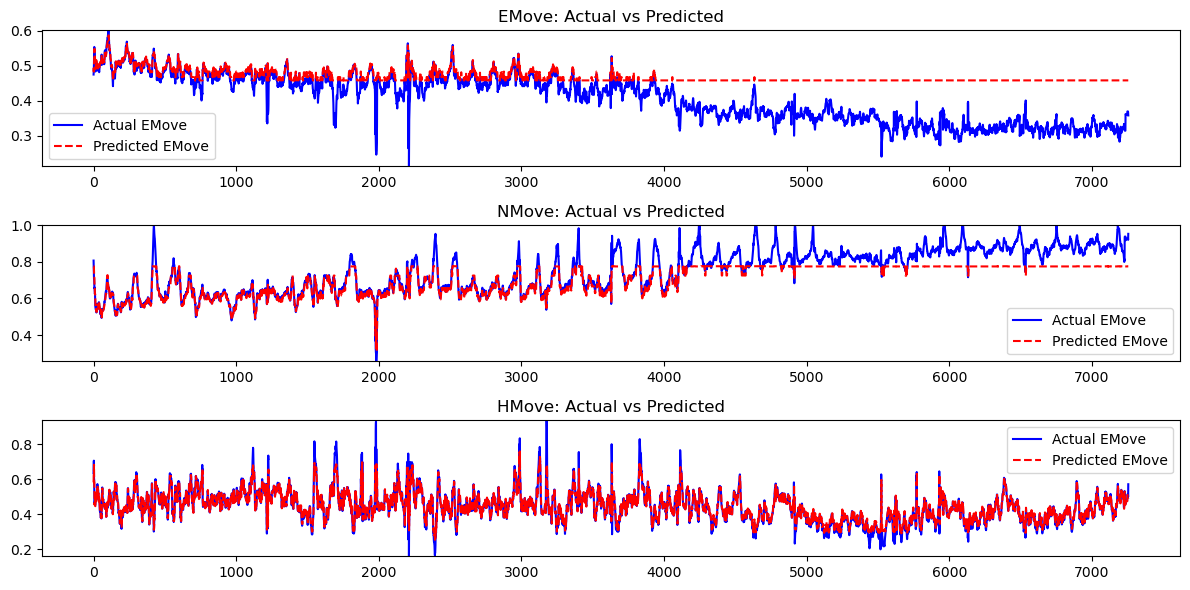

In [92]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plot predictions vs actual values for each movement component
y_min = -50  # 最小值
y_max = 50  # 最大值
plt.figure(figsize=(12, 6))
subplot_i=0

for t in target:
    plt.subplot(3, 1, subplot_i+1)
    y_min = min([ np.min(y_test[t].to_numpy(), axis=0) , np.min(y_pred[:,subplot_i], axis=0) ])
    y_max = max([ np.max(y_test[t].to_numpy(), axis=0) , np.max(y_pred[:,subplot_i], axis=0) ])
    plt.plot(y_test[t].to_numpy(), label="Actual EMove", color='blue')
    plt.plot(y_pred[:,subplot_i], label="Predicted EMove", color='red', linestyle='dashed')
    plt.title("{}: Actual vs Predicted".format(t))
    plt.ylim(y_min, y_max)  # Set same y-axis range
    plt.legend()
    subplot_i += 1

plt.tight_layout()
plt.show()